In [218]:
from openpyxl import load_workbook
import pandas as pd
from datetime import datetime
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm, gamma
from scipy.optimize import minimize
import sknetwork as skn
from sklearn import preprocessing
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
from dtaidistance import dtw
from scipy.spatial import distance
import networkx as nx

In [219]:
df = pd.read_csv('3.csv')
df = df.drop(columns = ['Unnamed: 0'])


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

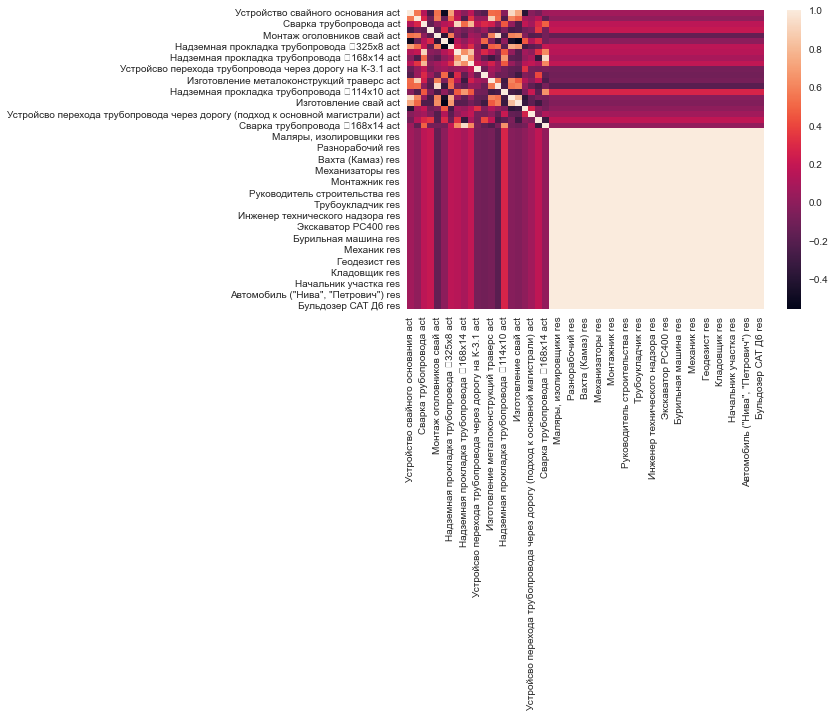

In [220]:
corr = df.corr('spearman')
sns.heatmap(corr)

In [221]:
corr

,Устройство свайного основания act,Монтаж металоконструкций траверс act,Сварка трубопровода act,Испытание трубопровода act,Монтаж оголовников свай act,Отсыпка act,Надземная прокладка трубопровода ⌀325х8 act,Надземная прокладка трубопровода act,Надземная прокладка трубопровода ⌀168х14 act,"Монтаж опор (направляющие, скользящие, неподвижные) act",...,ИТР res,Геодезист res,Инженер по охране труда res,Кладовщик res,Электросварщики res,Начальник участка res,Топливозаправщик res,"Автомобиль (""Нива"", ""Петрович"") res",ППУ res,Бульдозер САТ Д6 res
Устройство свайного основания act,1.000000,0.561452,0.136497,-0.269121,0.537431,-0.502586,0.706667,0.129956,-0.020176,0.160187,...,0.066946,0.066946,0.066946,0.066946,0.066946,0.066946,0.066946,0.066946,0.066946,0.066946
Монтаж металоконструкций траверс act,0.561452,1.000000,0.281317,-0.099611,0.577777,-0.139640,0.524230,0.187743,-0.241266,0.333321,...,0.005257,0.005257,0.005257,0.005257,0.005257,0.005257,0.005257,0.005257,0.005257,0.005257
Сварка трубопровода act,0.136497,0.281317,1.000000,-0.167347,0.003013,0.140760,0.200054,0.912758,0.518214,0.788497,...,0.161831,0.161831,0.161831,0.161831,0.161831,0.161831,0.161831,0.161831,0.161831,0.161831
Испытание трубопровода act,-0.269121,-0.099611,-0.167347,1.000000,-0.190992,0.292160,-0.169524,-0.014377,-0.094635,0.000000,...,0.202529,0.202529,0.202529,0.202529,0.202529,0.202529,0.202529,0.202529,0.202529,0.202529
Монтаж оголовников свай act,0.537431,0.577777,0.003013,-0.190992,1.000000,-0.371538,0.571136,-0.045732,-0.178858,0.076270,...,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168,-0.156168
Отсыпка act,-0.502586,-0.139640,0.140760,0.292160,-0.371538,1.000000,-0.540396,0.133857,0.005999,0.151492,...,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319,-0.004319
Надземная прокладка трубопровода ⌀325х8 act,0.706667,0.524230,0.200054,-0.169524,0.571136,-0.540396,1.000000,0.243136,0.112141,0.311809,...,0.166508,0.166508,0.166508,0.166508,0.166508,0.166508,0.166508,0.166508,0.166508,0.166508
Надземная прокладка трубопровода act,0.129956,0.187743,0.912758,-0.014377,-0.045732,0.133857,0.243136,1.000000,0.646339,0.830910,...,0.144310,0.144310,0.144310,0.144310,0.144310,0.144310,0.144310,0.144310,0.144310,0.144310
Надземная прокладка трубопровода ⌀168х14 act,-0.020176,-0.241266,0.518214,-0.094635,-0.178858,0.005999,0.112141,0.646339,1.000000,0.647231,...,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593
"Монтаж опор (направляющие, скользящие, неподвижные) act",0.160187,0.333321,0.788497,0.000000,0.076270,0.151492,0.311809,0.830910,0.647231,1.000000,...,0.181122,0.181122,0.181122,0.181122,0.181122,0.181122,0.181122,0.181122,0.181122,0.181122


In [222]:
corr.fillna(0, inplace=True)
corr = corr.apply(np.abs)

In [223]:
def get_n_nearest(data, columns, number_act=5, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values(ascending=False).index
        close_act = []
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'act':
                close_act.append(element)
            else:
                close_res.append(element)
        groups.append(close_act[0:number_act] + close_res[0:number_res])
    return groups



In [224]:
columns = df.columns.tolist()
groups = get_n_nearest(corr, columns)

In [245]:
groups

[['Устройство свайного основания act',
  'Бурение скважин act',
  'Изготовление свай act',
  'Надземная прокладка трубопровода ⌀325х8 act',
  'Монтаж металоконструкций траверс act',
  'ИТР res',
  'А/м для перевозки воды res',
  'Экскаватор РС400 res',
  'Газорезчик res',
  'Бурильная машина res'],
 ['Монтаж металоконструкций траверс act',
  'Изготовление металоконструкций траверс act',
  'Бурение скважин act',
  'Монтаж оголовников свай act',
  'Устройство свайного основания act',
  'А/м для перевозки воды res',
  'Геодезист res',
  'Газорезчик res',
  'Бурильная машина res',
  'Бетонщик res'],
 ['Сварка трубопровода act',
  'Надземная прокладка трубопровода act',
  'Монтаж опор (направляющие, скользящие, неподвижные) act',
  'Надземная прокладка трубопровода ⌀168х14 act',
  'Сварка трубопровода ⌀168х14 act',
  'Экскаватор РС400 res',
  'ИТР res',
  'Газорезчик res',
  'Бурильная машина res',
  'Бетонщик res'],
 ['Испытание трубопровода act',
  'Надземная прокладка трубопровода ⌀159х6

In [226]:
nets = []
for i in range(len(groups)):
    nets.append('net'+ str(i))


rows = len(columns)
cols = len(nets)
brave = pd.DataFrame(data=np.zeros((rows, cols)), columns=nets)
brave.index = columns


In [227]:
for c in columns:
    for i, g in enumerate(groups):
        if c in g:
            brave.loc[c,'net'+str(i)] = 1


In [228]:
brave_coef = pd.DataFrame(data=np.zeros((rows,rows)), columns=columns)
brave_coef.index = columns


In [229]:
for c1 in columns:
    for c2 in columns:
        a = 0
        b = 0
        c = 0
        d = 0
        if c1 == c2:
            brave_coef.loc[c1,c2] = 0
        elif (c1.split()[-1] == 'res') & (c2.split()[-1] == 'act'):
            brave_coef.loc[c1,c2] = 0
        else:
            for j in nets:
                if (brave.loc[c1,j] == 1) & (brave.loc[c2,j] == 1):
                    a += 1
                if (brave.loc[c1,j] == 1) & (brave.loc[c2,j] == 0):
                    b += 1
                if (brave.loc[c1,j] == 0) & (brave.loc[c2,j] == 1):
                    c += 1
                if (brave.loc[c1,j] == 0) & (brave.loc[c2,j] == 0):
                    d += 1
            br = (a*len(nets) + (a+c)*(a+b)) / (math.sqrt((a + c + 0.0000000001)*(b+d + 0.0000000001))) * (math.sqrt((a+b + 0.0000000001)*(c+d + 0.0000000001)))
            brave_coef.loc[c1,c2] = br
    


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

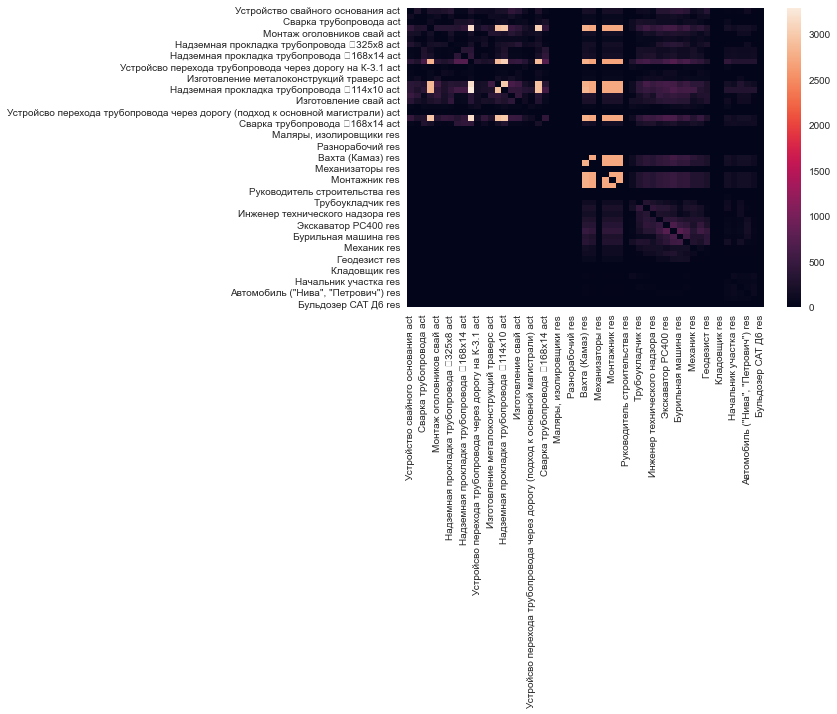

In [230]:
sns.heatmap(brave_coef)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

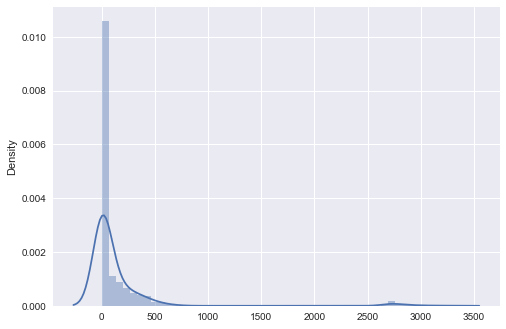

In [231]:
sns.distplot(brave_coef)

In [232]:
df = df.astype(int)
node_types = get_nodes_type(df)

In [233]:
groups_edges = []
for i, g in enumerate(groups):
    print(i)
    blacklist = []
    for c1 in g:
        for c2 in g:
            if (c1.split()[-1] == 'res') & (c2.split()[-1] == 'act'):
                blacklist.append((c1,c2))
    bn = structure_learning(df[g], 'HC', node_types, 'BIC', black_list=blacklist)
    groups_edges.append(bn['E'])
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


In [234]:
rows = len(columns)
cols = len(columns)
brave = pd.DataFrame(data=np.zeros((rows, cols)), columns=columns)
brave.index = columns


In [235]:
for c1 in columns:
    for c2 in columns:
        for i, net in enumerate(groups_edges):
            if [c1, c2] in net:
                brave.loc[c1,c2] += 1

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

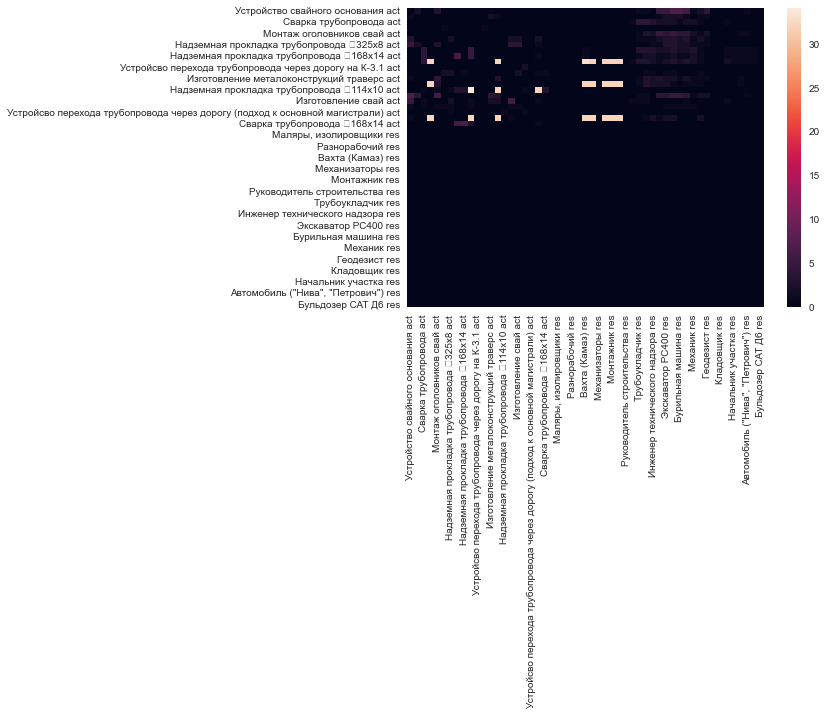

In [236]:
sns.heatmap(brave)

In [237]:
final_matrix = brave_coef.add(brave)
final_matrix

,Устройство свайного основания act,Монтаж металоконструкций траверс act,Сварка трубопровода act,Испытание трубопровода act,Монтаж оголовников свай act,Отсыпка act,Надземная прокладка трубопровода ⌀325х8 act,Надземная прокладка трубопровода act,Надземная прокладка трубопровода ⌀168х14 act,"Монтаж опор (направляющие, скользящие, неподвижные) act",...,ИТР res,Геодезист res,Инженер по охране труда res,Кладовщик res,Электросварщики res,Начальник участка res,Топливозаправщик res,"Автомобиль (""Нива"", ""Петрович"") res",ППУ res,Бульдозер САТ Д6 res
Устройство свайного основания act,0.000000,260.855014,48.989795,242.615393,230.332629,258.855014,339.412902,54.233538,59.212220,241.594702,...,175.999266,334.683892,0.0,0.0,30.058766,21.049392,30.058766,130.628428,21.049392,0.0
Монтаж металоконструкций траверс act,141.932174,0.000000,18.073922,74.911878,104.545393,16.000000,104.545393,20.008509,21.845306,89.132112,...,109.379423,123.000000,0.0,0.0,11.089652,7.765803,11.089652,11.089652,7.765803,0.0
Сварка трубопровода act,32.659863,22.131333,0.000000,103.618734,30.216609,22.131333,30.216609,223.252552,213.242929,260.852045,...,77.570090,22.131333,0.0,0.0,97.637589,10.741723,15.339300,15.339300,10.741723,0.0
Испытание трубопровода act,435.359845,246.903435,278.907093,0.000000,337.105067,344.123156,337.105067,308.760597,412.174683,3180.968909,...,388.977811,246.903435,0.0,0.0,171.129581,119.837711,171.129581,171.129581,119.837711,0.0
Монтаж оголовников свай act,203.336407,171.753145,40.540617,168.030699,0.000000,35.888717,208.000000,44.879982,49.000000,199.927320,...,102.514245,173.753145,0.0,0.0,24.874587,17.419044,120.042668,120.042668,17.419044,0.0
Отсыпка act,143.932174,16.000000,18.073922,104.105478,21.845306,0.000000,106.545393,20.008509,21.845306,89.132112,...,110.379423,70.000000,0.0,0.0,11.089652,7.765803,11.089652,11.089652,7.765803,0.0
Надземная прокладка трубопровода ⌀325х8 act,308.585985,173.753145,40.540617,168.030699,211.000000,171.753145,0.000000,44.879982,49.000000,199.927320,...,159.148507,240.685359,0.0,0.0,24.874587,17.419044,24.874587,119.042668,17.419044,0.0
Надземная прокладка трубопровода act,42.482938,28.787752,266.321749,134.784038,39.304829,28.787752,39.304829,0.000000,336.898532,351.764033,...,90.000000,28.787752,0.0,0.0,109.078131,138.396255,109.078131,109.078131,138.396255,0.0
Надземная прокладка трубопровода ⌀168х14 act,52.962041,35.888717,290.100929,205.449300,49.000000,35.888717,49.000000,390.685558,0.000000,404.103034,...,159.148507,35.888717,0.0,0.0,120.042668,150.306087,120.042668,120.042668,150.306087,0.0
"Монтаж опор (направляющие, скользящие, неподвижные) act",382.524945,259.210733,623.523607,2838.737273,353.908610,259.210733,353.908610,700.906025,706.486737,0.000000,...,400.502217,259.210733,0.0,0.0,432.237964,302.284749,305.948887,305.948887,302.284749,0.0


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

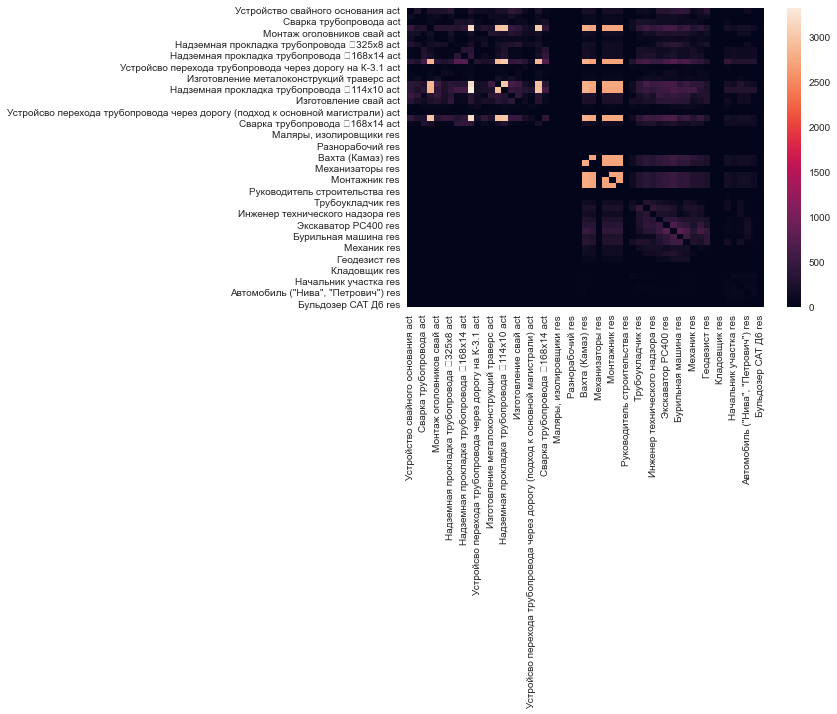

In [238]:
sns.heatmap(final_matrix)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

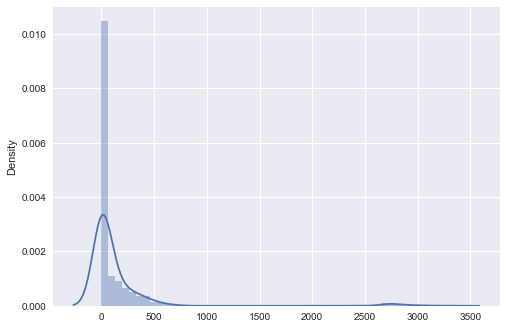

In [239]:
sns.distplot(final_matrix)

In [240]:
bn_new = dict()
bn_new['V'] = columns
bn_new['E'] = []
for c1 in columns:
    for c2 in columns:
        if final_matrix.loc[c1,c2] > 300:
            bn_new['E'].append((c1, c2))



C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


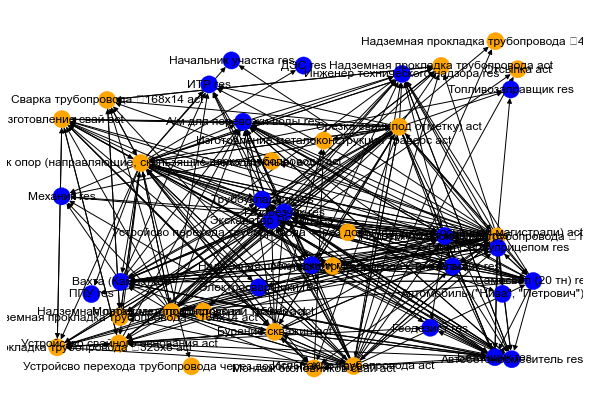

In [241]:
G = nx.DiGraph()
G.add_edges_from(
    bn_new['E'])
color_map = []
for node in G:
    if node.split()[-1] == 'act':
        color_map.append('orange')
    else: 
        color_map.append('blue')      

nx.draw_random(G, node_color=color_map, with_labels=True)